In [1]:
import pandas as pd
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt

from tqdm import tqdm
from sentence_transformers import SentenceTransformer


In [2]:
# Check if GPU is available
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

In [3]:
# Load your data
file_path = 'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/Data/reddit_processed.csv'
df = pd.read_csv(file_path)

# Define the hypotheses and encode them
hypotheses = [
    "Personal experiences with surveillance cameras significantly shape people's views on public monitoring.",
    "Attitudes toward surveillance cameras vary significantly depending on their placement in different settings, such as shopping areas, residential blocks, and workplaces.",
    "There are common technical complaints about surveillance cameras, and people suggest specific enhancements to address these issues.",
    "Surveillance cameras make people feel more secure rather than feeling watched.",
    "There is a noticeable relationship between the density of surveillance cameras in an area and public opinion regarding their presence."
]
# hypotheses = [
#     "People feel that surveillance cameras in public spaces negatively impact their privacy.",
#     "Individuals believe that surveillance cameras effectively reduce crime in their neighborhoods and public areas.",
#     "Personal experiences with surveillance cameras significantly shape people's views on public monitoring.",
#     "Trust in the organizations that manage surveillance cameras is influenced by specific factors such as transparency and accountability.",
#     "Attitudes toward surveillance cameras vary significantly depending on their placement in different settings, such as shopping areas, residential blocks, and workplaces.",
#     "There are common technical complaints about surveillance cameras, and people suggest specific enhancements to address these issues.",
#     "Surveillance cameras make people feel more secure rather than feeling watched.",
#     "There is a noticeable relationship between the density of surveillance cameras in an area and public opinion regarding their presence."
# ]

In [4]:
df

,subreddit,msg_type,score,link,author,datetime,thread_id,comment_id,title,thread_text,title_processed,thread_text_processed,combined_processed
0,AskEurope,thread_start,0,https://www.reddit.com/r/AskEurope/comments/44...,u/Just-An-Asshole,2016-02-08 23:02:00,44szks,0,Question about the UK Court System,Hello! I just finished reading [this article]...,question about the uk court system,question about the uk court system hello i jus...,question about the uk court system hello i jus...
1,AskEurope,comment,8,https://www.reddit.com/r/AskEurope/comments/44...,u/lgf92,2016-02-08 23:59:00,44szks,czspr8i,Question about the UK Court System,There's almost certainly more to it than is be...,question about the uk court system,there is almost certainly more to it than is b...,question about the uk court system there is al...
2,AskEurope,comment,3,https://www.reddit.com/r/AskEurope/comments/44...,u/mrNONDESCRIPT,2016-02-09 00:12:00,44szks,czsqabq,Question about the UK Court System,"We have two types of court, Magistrate Courts ...",question about the uk court system,we have two types of court magistrate courts a...,question about the uk court system we have two...
3,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/nearlydeadasababy,2016-02-09 17:33:00,44szks,czthzzh,Question about the UK Court System,&gt; that at least merits some investigation\...,question about the uk court system,that at least merits some investigation as al...,question about the uk court system that at le...
4,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/hoffi_coffi,2016-02-11 17:01:00,44szks,czw1jl9,Question about the UK Court System,"It was a bit of an anomaly, hence it made the ...",question about the uk court system,it was a bit of an anomaly hence it made the n...,question about the uk court system it was a bi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
583766,technology,thread_start,7930,https://www.reddit.com/r/technology/comments/z...,u/psychothumbs,2022-12-31 16:48:00,zzvntv,0,Sex Workers Have Been Banned From Airbnb for Y...,NaN,sex workers have been banned from airbnb for y...,sex workers have been banned from airbnb for y...,sex workers have been banned from airbnb for y...
583767,technology,thread_start,2624,https://www.reddit.com/r/technology/comments/z...,u/nyphrex,2012-09-17 04:02:00,zzyir,0,The light bulb... reinvented,NaN,the light bulb reinvented,the light bulb reinvented nan,the light bulb reinvented
583768,technology,comment,2,https://www.reddit.com/r/technology/comments/z...,u/AmericCanuck,2012-09-17 08:37:00,zzyir,c69aghb,The light bulb... reinvented,"Old technology. Google Insteon, universal-dev...",the light bulb reinvented,old technology google insteon complete home s...,the light bulb reinvented old technology googl...
583769,technology,comment,1,https://www.reddit.com/r/technology/comments/z...,u/[deleted],2012-09-17 10:09:00,zzyir,c69bbhb,The light bulb... reinvented,"Honestly, if the bulb lasts even 10 years I wo...",the light bulb reinvented,honestly if the bulb lasts even years i would...,the light bulb reinvented honestly if the bulb...


In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the SentenceTransformer model and send it to the device
model = SentenceTransformer("Snowflake/snowflake-arctic-embed-s").to(device)
hypothesis_embeddings = model.encode(hypotheses, convert_to_tensor=True, device=device).cpu()

# Save hypothesis embeddings
with open('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/hypothesis_embeddings.pkl', 'wb') as f:
    torch.save(hypothesis_embeddings, f)

You try to use a model that was created with version 2.7.0.dev0, however, your version is 2.7.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





In [4]:
# Load saved embeddings
hypothesis_embeddings = torch.load('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/hypothesis_embeddings.pkl')

In [5]:
texts = df['combined_processed'].tolist()

# Generate embeddings in batches
batch_size = 10000
combined_embeddings = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Load the SentenceTransformer model and send it to the device
model = SentenceTransformer("Snowflake/snowflake-arctic-embed-s").to(device)

for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
    batch_texts = texts[i:i + batch_size]
    batch_embeddings = model.encode(batch_texts, convert_to_tensor=True, device=device).cpu()
    combined_embeddings.append(batch_embeddings)

# Concatenate all batches
combined_embeddings = torch.cat(combined_embeddings, dim=0)

# Save text embeddings
with open('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/combined_embeddings.pkl', 'wb') as f:
    torch.save(combined_embeddings, f)

You try to use a model that was created with version 2.7.0.dev0, however, your version is 2.7.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.



Processing batches: 100%|██████████| 59/59 [16:31<00:00, 16.80s/it]


In [5]:
# Load saved embeddings
combined_embeddings = torch.load('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/combined_embeddings.pkl')

In [6]:
# Calculate cosine similarity between text and hypothesis embeddings
# thread_text_similarity_scores = torch.mm(thread_text_embeddings, hypothesis_embeddings.T).cpu().numpy()
combined_similarity_scores = torch.mm(combined_embeddings, hypothesis_embeddings.T).cpu().numpy()

# Save similarity scores
# with open('thread_text_similarity_scores.pkl', 'wb') as f:
#     pickle.dump(thread_text_similarity_scores, f)
# Save similarity scores
with open('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/combined_similarity_scores.pkl', 'wb') as f:
    pickle.dump(combined_similarity_scores, f)

In [5]:
# similarity_scores = torch.load('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/Data/similarity_scores.pkl')
# Loading with pickle
# with open('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/Data/thread_text_similarity_scores.pkl', 'rb') as f:
#     thread_text_similarity_scores = pickle.load(f)
with open('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/combined_similarity_scores.pkl', 'rb') as f:
    combined_similarity_scores = pickle.load(f)

C:\Users\fahad\.conda\envs\torch\Lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\fahad\.conda\envs\torch\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\fahad\.conda\envs\torch\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


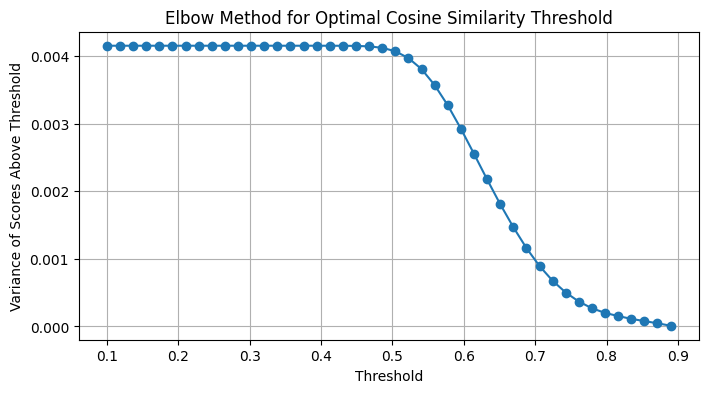

In [6]:
# Assuming 'similarity_scores' is a 2D array where each row corresponds to a document and each column to a hypothesis
thresholds = np.linspace(0.1, 1, 50)  # Adjust as needed for your range of similarity scores
variances = []

for threshold in thresholds:
    filtered_scores = combined_similarity_scores[combined_similarity_scores > threshold]
    variance = np.var(filtered_scores)
    variances.append(variance)

# Plotting the elbow plot
plt.figure(figsize=(8, 4))
plt.plot(thresholds, variances, marker='o')
plt.title('Elbow Method for Optimal Cosine Similarity Threshold')
plt.xlabel('Threshold')
plt.ylabel('Variance of Scores Above Threshold')
plt.grid(True)
plt.show()


In [7]:
threshold = 0.5
max_scores = np.max(combined_similarity_scores, axis=1)
df_temp = pd.DataFrame()
df_temp['Max_Similarity_Score'] = max_scores
df_temp['classified'] = df_temp['Max_Similarity_Score'] >= threshold

# Count classified and unclassified
classified_count = df_temp['classified'].sum()
unclassified_count = (~df_temp['classified']).sum()

print(f"Classified Rows: {classified_count}")
print(f"Unclassified Rows: {unclassified_count}")

Classified Rows: 583667
Unclassified Rows: 104


In [8]:
threshold = 0.5
max_indices = np.argmax(combined_similarity_scores, axis=1)  # Indices of max similarity score per row
max_scores = np.max(combined_similarity_scores, axis=1)  # Max scores per row

# Map indices to hypothesis labels if score exceeds threshold, else assign -1
hypothesis_labels = {i: f'H{i}' for i in range(len(hypotheses))}
df['hypothesis'] = [hypothesis_labels[idx] if score > threshold else -1 for idx, score in zip(max_indices, max_scores)]

In [9]:
# Save the DataFrame with the hypothesis mapping
df.to_csv('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/Data/reddit_with_hypotheses.csv', index=False)

hypothesis
H3    221101
H2    134703
H0    106510
H1     85485
H4     35868
-1       104
Name: count, dtype: int64


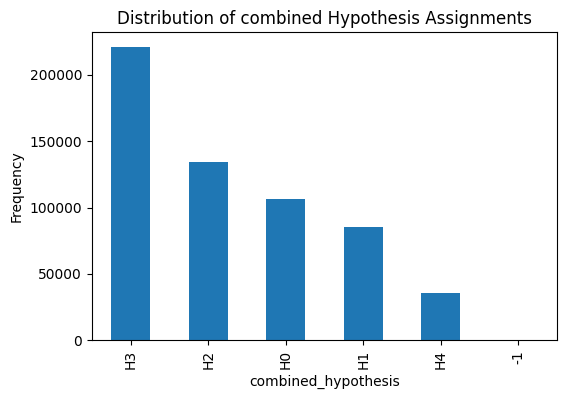

In [10]:
# Optional: Display a histogram of the assigned hypotheses
print(df['hypothesis'].value_counts())
df['hypothesis'].value_counts().plot(kind='bar', figsize=(6,4))
plt.title('Distribution of combined Hypothesis Assignments')
plt.xlabel('combined_hypothesis')
plt.ylabel('Frequency')
plt.show()

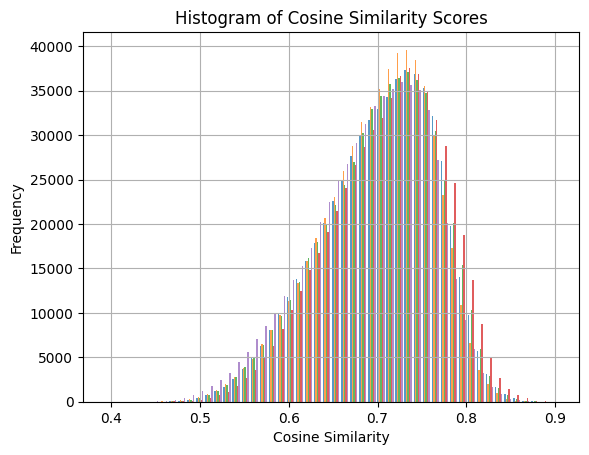

In [11]:
# Assuming `similarity_scores` is a numpy array of your cosine similarity scores
plt.hist(combined_similarity_scores, bins=50, alpha=0.75)
plt.title('Histogram of Cosine Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [12]:
df

,subreddit,msg_type,score,link,author,datetime,thread_id,comment_id,title,thread_text,title_processed,thread_text_processed,combined_processed,hypothesis
0,AskEurope,thread_start,0,https://www.reddit.com/r/AskEurope/comments/44...,u/Just-An-Asshole,2016-02-08 23:02:00,44szks,0,Question about the UK Court System,Hello! I just finished reading [this article]...,question about the uk court system,question about the uk court system hello i jus...,question about the uk court system hello i jus...,H0
1,AskEurope,comment,8,https://www.reddit.com/r/AskEurope/comments/44...,u/lgf92,2016-02-08 23:59:00,44szks,czspr8i,Question about the UK Court System,There's almost certainly more to it than is be...,question about the uk court system,there is almost certainly more to it than is b...,question about the uk court system there is al...,H2
2,AskEurope,comment,3,https://www.reddit.com/r/AskEurope/comments/44...,u/mrNONDESCRIPT,2016-02-09 00:12:00,44szks,czsqabq,Question about the UK Court System,"We have two types of court, Magistrate Courts ...",question about the uk court system,we have two types of court magistrate courts a...,question about the uk court system we have two...,H2
3,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/nearlydeadasababy,2016-02-09 17:33:00,44szks,czthzzh,Question about the UK Court System,&gt; that at least merits some investigation\...,question about the uk court system,that at least merits some investigation as al...,question about the uk court system that at le...,H2
4,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/hoffi_coffi,2016-02-11 17:01:00,44szks,czw1jl9,Question about the UK Court System,"It was a bit of an anomaly, hence it made the ...",question about the uk court system,it was a bit of an anomaly hence it made the n...,question about the uk court system it was a bi...,H4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583766,technology,thread_start,7930,https://www.reddit.com/r/technology/comments/z...,u/psychothumbs,2022-12-31 16:48:00,zzvntv,0,Sex Workers Have Been Banned From Airbnb for Y...,NaN,sex workers have been banned from airbnb for y...,sex workers have been banned from airbnb for y...,sex workers have been banned from airbnb for y...,H1
583767,technology,thread_start,2624,https://www.reddit.com/r/technology/comments/z...,u/nyphrex,2012-09-17 04:02:00,zzyir,0,The light bulb... reinvented,NaN,the light bulb reinvented,the light bulb reinvented nan,the light bulb reinvented,H2
583768,technology,comment,2,https://www.reddit.com/r/technology/comments/z...,u/AmericCanuck,2012-09-17 08:37:00,zzyir,c69aghb,The light bulb... reinvented,"Old technology. Google Insteon, universal-dev...",the light bulb reinvented,old technology google insteon complete home s...,the light bulb reinvented old technology googl...,H2
583769,technology,comment,1,https://www.reddit.com/r/technology/comments/z...,u/[deleted],2012-09-17 10:09:00,zzyir,c69bbhb,The light bulb... reinvented,"Honestly, if the bulb lasts even 10 years I wo...",the light bulb reinvented,honestly if the bulb lasts even years i would...,the light bulb reinvented honestly if the bulb...,H2
